In [8]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import cho_factor, cho_solve
import time
from jax import random, jit
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt


### Comparison of approaches for computing diagonal elements of the inverse of a kernel matrix

In [6]:
# This was just for testing if the current implementation for computing the diagonal of the inverse kernel matrix wasn't 

# Function for the initial implementation
def compute_diag_inv_initial(K):
    K_chol, _ = cho_factor(K, lower=True)
    compute_diag = jax.vmap(lambda A, b, i: cho_solve((A, True), b)[i], in_axes=(None, 0, 0))
    diag_inv_K = compute_diag(K_chol, jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0]))
    return diag_inv_K

# Function for the optimized implementation
def compute_diag_inv_optimized(K):
    K_chol, lower = cho_factor(K, lower=True)
    I = jnp.eye(K.shape[0])
    
    def solve_system(e_i):
        return cho_solve((K_chol, lower), e_i)
    
    solutions = jax.vmap(solve_system)(I)
    diag_elements = jnp.diag(solutions)
    
    return diag_elements

# Compile the functions with jit
compute_diag_inv_initial_jit = jit(compute_diag_inv_initial)
compute_diag_inv_optimized_jit = jit(compute_diag_inv_optimized)

# Function to compare the results and measure execution time
def test_speed_and_accuracy(K):
    # Test initial implementation
    start_time = time.time()
    diag_initial = compute_diag_inv_initial_jit(K)
    time_initial = time.time() - start_time
    
    # Test optimized implementation
    start_time = time.time()
    diag_optimized = compute_diag_inv_optimized_jit(K)
    time_optimized = time.time() - start_time
    
    # Compare results
    accuracy = jnp.allclose(diag_initial, diag_optimized)
    
    return time_initial, time_optimized, accuracy

# Example usage with a large random positive-definite matrix
time_1 = []
time_2 = []
acc = []
for i,N in tqdm(enumerate([1000,2000,3000,4000,5000,6000,7000])):
    key = jax.random.PRNGKey(i+56)
    A = jax.random.normal(key, (N, N))
    K = A @ A.T + N * jnp.eye(N)  # Make it positive definite

    time_initial, time_optimized, accuracy = test_speed_and_accuracy(K)
    # print(f"Initial implementation time: {time_initial:.6f} seconds")
    # print(f"Optimized implementation time: {time_optimized:.6f} seconds")
    # print(f"Accuracy (allclose): {accuracy}")

    time_1.append(time_initial)
    time_2.append(time_optimized)
    acc.append(accuracy)


0it [00:00, ?it/s]

7it [00:15,  2.18s/it]


Size 1000, Accuracy: True
Size 2000, Accuracy: True
Size 3000, Accuracy: True
Size 4000, Accuracy: True
Size 5000, Accuracy: True
Size 6000, Accuracy: True
Size 7000, Accuracy: True


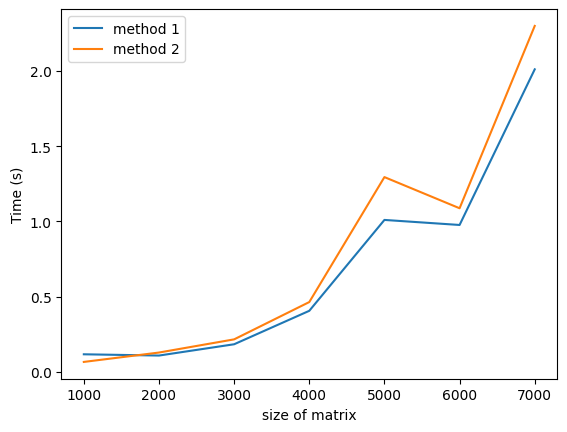

In [9]:
plt.plot([1000,2000,3000,4000,5000,6000,7000], time_1, label = "method 1")
plt.plot([1000,2000,3000,4000,5000,6000,7000], time_2, label = "method 2")
plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('size of matrix')

sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000]
for i, acc in enumerate(acc):
        print(f"Size {sizes[i]}, Accuracy: {acc}")

In [10]:
def compute_diag_inv_cholesky(K):
    """
    Compute the diagonal elements of the inverse of a positive definite matrix K using Cholesky decomposition.
    
    Parameters:
    K (jax.numpy.ndarray): The input kernel matrix (N x N).
    
    Returns:
    jax.numpy.ndarray: The diagonal elements of the inverse of K.
    """
    # Perform Cholesky factorization
    K_chol, lower = cho_factor(K, lower=True)
    
    # Identity matrix
    I = jnp.eye(K.shape[0])
    
    # Function to solve the linear system for each column of the identity matrix
    def solve_system(e_i):
        return cho_solve((K_chol, lower), e_i)
    
    # Apply the solve_system function to each column of the identity matrix
    solutions = jax.vmap(solve_system)(I)
    
    # Extract the diagonal elements of the solution matrix
    diag_elements = jnp.diag(solutions)
    
    return diag_elements

# Exampl usage
K = jnp.array([[4.0, 1.0], [1.0, 3.0]])
diag_inv_K = compute_diag_inv_cholesky(K)
print(diag_inv_K)


[0.27272728 0.36363637]


In [11]:


def stochastic_diag_inv(K, num_samples=100, key=random.PRNGKey(0)):
    """
    Compute the diagonal elements of the inverse of a matrix K using stochastic estimation.
    
    Parameters:
    K (jax.numpy.ndarray): The input kernel matrix (N x N).
    num_samples (int): Number of random samples to use for estimation.
    key (jax.random.PRNGKey): Random key for generating samples.
    
    Returns:
    jax.numpy.ndarray: The estimated diagonal elements of the inverse of K.
    """
    N = K.shape[0]
    keys = random.split(key, num_samples)
    K_cho,_ = cho_factor(K,True)
    
    def single_sample(key):
        z = random.normal(key, (N,))
        v = jax.scipy.linalg.cho_solve((K_cho,True), z)
        return v * z

    samples = jax.vmap(single_sample)(keys)
    diag_estimate = jnp.mean(samples, axis=0)
    
    return diag_estimate

# Example usage
# K = jnp.array([[4.0, 1.0], [1.0, 3.0]])
N=10
key = jax.random.PRNGKey(45)
A = jax.random.normal(key, (N, N))
K = A @ A.T + N * jnp.eye(N)  # Make it positive definite
diag_inv_K = stochastic_diag_inv(K,num_samples=100)
print(diag_inv_K)
true_diag_inv_K = jnp.diag(jax.scipy.linalg.inv(K))
print(true_diag_inv_K)
print(jnp.allclose(diag_inv_K, true_diag_inv_K))

[0.09066722 0.06164361 0.07276236 0.0637615  0.08210775 0.05714661
 0.06784956 0.05641109 0.04231799 0.07338811]
[0.07212101 0.05267652 0.05955045 0.05813286 0.07669569 0.0432749
 0.05262708 0.05604875 0.04857801 0.06648815]
False
